In [54]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Count:", torch.cuda.device_count())
print("Current Device Index:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA Available: True
GPU Count: 1
Current Device Index: 0
GPU Name: NVIDIA GeForce RTX 2080 Ti


In [2]:
import xmltodict, json
import os
import pandas as pd
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations
import json, re

# Load Raw Dataset

In [3]:
# Change to path to the data
# path = '/home/wt/Downloads/n2c2 2012/'
# wp = '/home/jovyan/work/Temporal_relation/'
wp = "./"
path = wp + 'data/i2b2/'
training_data_path = path + 'timeline_training'
test_data_path = path + 'ground_truth/unmerged_xml'

In [4]:
def data_loader(data_path):
    """data: {
        filename: {
            "ClinicalNarrativeTemporalAnnotation":{
                "TEXT": text,
                "TAGS": {
                    'EVENT': list({
                        'id':id, 
                        'start':start position, 
                        'end': end position, 
                        'text': text, 
                        'modality': whether an EVENT actually occurred or not ('FACTUAL','CONDITIONAL','POSSIBLE','PROPOSED') 
                        'polarity': positive or negative ('POS'/'NEG'), 
                        'type': event type ('TEST','PROBLEM','TREATMENT','CLINICAL_DEPT','EVIDENTIAL','OCCURENCE')
                        }),
                    'TIMEX3':list({
                        'id':id, 
                        'start':start position, 
                        'end': end position, 
                        'text': text, 
                        'type': event type ('DATE','TIME','DURATION','FREQUENCY'),
                        'val': regularised time expression,
                        'mod': modifier for regularised time expression,
                        }),
                    'TLINK':list({
                        'id':id, 
                        'fromID': head event/timex3 id, 
                        'fromText': head event/timex3 text, 
                        'toID': tail event/timex3 id, 
                        'toText': tail event/timex3 text,
                        'type': temporal relation type ('BEFORE', 'AFTER', 'OVERLAP'),
                        }),
                    'SECTIME': list({
                        'id': id, 
                        'start':start position, 
                        'end': end position, 
                        'text': text, 
                        'type': 'ADMISSION'/'DISCHARGE',
                        'dvalue': regularised date time,
                        }),
                }
            }
        }
    }
    """
    data = {}
    for filename in os.listdir(data_path):
        if filename.endswith(".xml"): 
            f = (os.path.join(data_path, filename))
#             print(f)
            fb = open(f, "rb").read().decode(encoding="utf-8")
#     invalid character '&' https://github.com/martinblech/xmltodict/issues/277
            fb = fb.replace('&', '&amp;')
            dic = xmltodict.parse(fb, attr_prefix='')
#     restore orginal character "&"
            dic['ClinicalNarrativeTemporalAnnotation']['TEXT'] = dic['ClinicalNarrativeTemporalAnnotation']['TEXT'].replace('&amp;', '&')
            data[filename] = (dic)
    return data

In [5]:
train_data = data_loader(training_data_path)
test_data = data_loader(test_data_path)

In [7]:
print(len(train_data), len(test_data))

190 120


In [6]:
def find_first_regex(text, substrings):
    pattern = '|'.join(map(re.escape, substrings))  # Escape special characters
    match = re.search(pattern, text, re.IGNORECASE)
    if match:
        return match.start()
    else:
        raise ValueError("None of the substrings found in the text.")

In [7]:

def build_section_graph(doc_id, data):
    """构建完整的图，不做任何过滤，并补全边的对称关系。
    注：根据时序关系对某些边进行了反向处理，同时对于SIMULTANEOUS，OVERLAP进行了双向处理；
    具体操作的时候，先对所有边构建了反向边；然后删掉了不想要的逆时序边；
    """
    
    text = data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TEXT']
    substrings = ['HOSPITAL COURSE']
    course_start = find_first_regex(text, substrings)

    # 读取事件信息
    events = pd.DataFrame(data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TAGS']['EVENT'])
    events['start'] = events['start'].astype(int)
    events['end'] = events['end'].astype(int)
    events['hospital_course'] = events['start'] > course_start


    # 读取时间信息
    times = pd.DataFrame(data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TAGS']['TIMEX3'])
    times['start'] = times['start'].astype(int)
    times['end'] = times['end'].astype(int)

    # 获取所有需要保留的节点
    nodes_keep = list(events['id']) + list(times['id'])

    # 读取时间关系（TLINK）
    all_links = pd.DataFrame(data[doc_id]['ClinicalNarrativeTemporalAnnotation']['TAGS']['TLINK'])
    all_links = all_links.loc[all_links['type'] != '']  # 只保留有意义的边

    # 构建有向图，添加原始变
    G = nx.from_pandas_edgelist(all_links[['fromID', 'toID', 'type']], source='fromID', target='toID', edge_attr=True, create_using=nx.DiGraph())
    
    # 添加事件和时间节点
    events = events.assign(event_or_time="event")
    times = times.assign(event_or_time="time")

    # 设置节点属性
    nx.set_node_attributes(G, events.set_index("id").to_dict(orient="index"))
    nx.set_node_attributes(G, times.set_index("id").to_dict(orient="index"))

    # 定义对称关系映射
    reciprocal_relations = {
        'BEFORE': 'AFTER',
        'AFTER': 'BEFORE',
        'SIMULTANEOUS': 'SIMULTANEOUS',
        'OVERLAP': 'OVERLAP',
        'BEGUN_BY': 'BEGINS',
        'BEGINS': 'BEGUN_BY',
        'ENDED_BY': 'ENDS',
        'ENDS': 'ENDED_BY',
        'DURING': 'COVER',
        'COVER': 'DURING',
        'BEFORE_OVERLAP': 'AFTER_OVERLAP',
        'AFTER_OVERLAP': 'BEFORE_OVERLAP'
    }

    # 遍历所有边，补全对称关系
    edges_to_add = []
    for u, v, data in G.edges(data=True):
        type_u_v = data.get('type', '').upper()  # 规范化大小写
        if u not in G[v]:  # 检查是否已经存在 v → u
            reciprocal_type = reciprocal_relations.get(type_u_v, None)
            if reciprocal_type:
                edges_to_add.append((v, u, reciprocal_type))
    # 添加补全的边
    for v, u, relation in edges_to_add:
        G.add_edge(v, u, type=relation)

    # 过滤逆时序边
    edge_types_to_remove = {'AFTER', 'BEGUN_BY', 'ENDS', 'DURING', 'AFTER_OVERLAP'}
    
    # 过滤出要删除的边
    edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') in edge_types_to_remove]
    # 删除边
    G.remove_edges_from(edges_to_remove)


    # 只保留 nodes_keep 里的节点
    G = G.subgraph(nodes_keep).copy()

    return G, text

def preprocess_time_overlap_edges(graph):
    tmp_graph = graph.copy()
    # Step 1: 查找类型为 DURATION, TIME, DATE 的节点
    temporal_types = {'DURATION', 'TIME', 'DATE'}
    temporal_nodes = {n for n, attr in graph.nodes(data=True) if attr.get('type').upper() in temporal_types}

    # Step 2: 替换与 temporal_nodes 相连且类型为 OVERLAP 的边为 SIMULTANEOUS
    for node in temporal_nodes:
        for successor in graph.successors(node):
            if graph.has_edge(node, successor):
                edge_data = graph.get_edge_data(node, successor)
                if edge_data.get('type').upper() == 'OVERLAP':
                    tmp_graph[node][successor]['type'] = 'SIMULTANEOUS'
        for predecessor in graph.predecessors(node):
            if graph.has_edge(predecessor, node):
                edge_data = graph.get_edge_data(predecessor, node)
                if edge_data.get('type').upper() == 'OVERLAP':
                    tmp_graph[predecessor][node]['type'] = 'SIMULTANEOUS'
    return tmp_graph


In [62]:
G, text = build_section_graph('526.xml', train_data)
G = preprocess_time_overlap_edges(G)

In [35]:
print(G.nodes['E16'].get('hospital_course'))

False


# Analysis Tools

In [9]:
def draw_graph(G, center_node=None, show_edge_labels=False):
    """
    center_node: 把指定节点放在中心；
    show_edge_labels: 是否标出边类型
    """
    # 获取节点类型
    time_nodes = [n for n, attr in G.nodes(data=True) if attr.get("type", "").lower() in ["date", "time"]]
    time_attr_nodes =  [n for n, attr in G.nodes(data=True) if attr.get("type", "").lower() in ["frequency", "duration"]]
    event_nodes = [n for n, attr in G.nodes(data=True) if attr.get("type", "").lower() in ["test", "problem", "treatment"]]
    occur_nodes = [n for n, attr in G.nodes(data=True) if attr.get("type", "").lower() in ["occurrence"]]
    event_attr_nodes = [n for n, attr in G.nodes(data=True) if attr.get("type", "").lower() in ["evidential", "clinical_dept"]]

    # 选择合适的布局
    if center_node and center_node in G: # 没找到好算法，还是比较丑
        # 以 center_node 为核心，其他节点围绕它
        # pos = nx.shell_layout(G, [ [center_node], list(set(G.nodes) - {center_node}) ])
        pos = nx.kamada_kawai_layout(G)
        # **固定 `center_node` 在中间**
        pos[center_node] = [0, 0]  # 将 center 放到中心
        # 重新调整 center附近的节点，使它们稍微分散
        for node in G.neighbors(center_node): 
            if node in pos:
                pos[node][0] += 0.5  # 轻微横向移动
    else:
        # 更均匀的布局
        pos = nx.kamada_kawai_layout(G)

    # 绘制图
    plt.figure(figsize=(20, 10))

    # 绘制 edges
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color="gray")

    # 绘制 event 节点（用蓝色）
    nx.draw_networkx_nodes(G, pos, nodelist=event_nodes, node_color="blue", node_size=40, label="Event Nodes")
    nx.draw_networkx_nodes(G, pos, nodelist=occur_nodes, node_color="green", node_size=40, label="Occurrence Nodes")
    nx.draw_networkx_nodes(G, pos, nodelist=event_attr_nodes, node_color="lightblue", node_size=40, label="Event Attr Nodes")

    # 绘制 time 节点 
    nx.draw_networkx_nodes(G, pos, nodelist=time_nodes, node_color="red", node_size=40, label="Time Nodes") 
    nx.draw_networkx_nodes(G, pos, nodelist=time_attr_nodes, node_color="pink", node_size=40, label="Time Attr Nodes")

    # 绘制 labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")

    # **绘制边的类型**
    if show_edge_labels:
        edge_labels = {(u, v): G[u][v].get("type", "") for u, v in G.edges()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_color="gray")

    # 显示图例
    plt.legend()
    plt.title("Graph")
    plt.show()

In [10]:
def print_node_connected_nodes(G, node):
    """
    打印连接到一个节点的邻居信息
    """
    attrs = G.nodes[node]
    print(f"Node: {node}, Type: {attrs['type']}, Text:{attrs['text']}")
    # 获取所有出边（node → neighbor）
    for neighbor in G.successors(node):  # 仅获取出边
        neighbor_type = G.nodes[neighbor].get("type", "Unknown")  # 获取邻居的类型
        neighbor_text = G.nodes[neighbor].get("text", "Unknown")
        edge_type = G.edges[node, neighbor].get("type", "Unknown")  # 获取边的类型
        print(f"    后继节点: {neighbor}, 类型: {neighbor_type}, 文本: {neighbor_text}, 关系: {edge_type}")

    # 获取所有入边（neighbor → node）
    for neighbor in G.predecessors(node):  # 仅获取入边
        neighbor_type = G.nodes[neighbor].get("type", "Unknown")  # 获取邻居的类型
        neighbor_text = G.nodes[neighbor].get("text", "Unknown")
        edge_type = G.edges[neighbor, node].get("type", "Unknown")  # 获取边的类型
        print(f"    前序节点: {neighbor}, 类型: {neighbor_type},  文本: {neighbor_text}, 关系: {edge_type}")

In [11]:
def print_paths(G, paths, abbr_path=True):
    """
    打印路径
    """
    for path in paths:
        formatted_path = []
        for i in range(len(path) - 1):
            n1, n2 = path[i], path[i + 1]
            n1_info = G.nodes[n1]
            n2_info = G.nodes[n2]
            relation = G.get_edge_data(n1, n2).get("type", "UNKNOWN")
            
            if abbr_path:
                formatted_path.append(f"{n1}")
            else:
                formatted_path.append(f"({n1}, {n1_info['type']}, {n1_info.get('text', '')})")
            
            formatted_path.append(f" -> [{relation}] -> ")
        
        last_node = G.nodes[path[-1]]
        if abbr_path:
            formatted_path.append(f"{path[-1]}")
        else:
            formatted_path.append(f"({path[-1]}, {last_node['type']}, {last_node.get('text', '')})")
        
        print("".join(formatted_path))

In [12]:
print_node_connected_nodes(G, 'E16')

Node: E16, Type: PROBLEM, Text:an abscess in the left lower extremity
    后继节点: E15, 类型: TREATMENT, 文本: resection, 关系: BEFORE
    后继节点: T0, 类型: DATE, 文本: 09/29/1993, 关系: BEFORE
    后继节点: E17, 类型: TREATMENT, 文本: any anti retroviral therapy, 关系: BEFORE


# Task 1: Start Time Inference
## - 数据构建：
1. 找到每个事件到Time or Date的路径
2. 根据逻辑推理事件的起始时间，或起始时间区间

__****UPDATED. Old version is above. Below NEW__

- 2.xml 速度慢是因为该图有很多paths. 
- 更新了代码：先 排查 OVERLAP 的edges 然后再找all all_simple_paths. 当 filter_overlap=True, 新版本快很多，但是其他两个 filter_mult_time_paths and filter_consecutive_durations 没有提升
- 另外一个改进是：在 NetworkX 的 all_simple_paths 函数中，可以将所有的汇点节点作为一个可迭代对象（如列表或集合）传递给 target 参数，而无需单独迭代每一对源-汇节点。​这样，函数将生成从指定源节点到任何一个目标节点的所有简单路径，从而提高效率。但源节点不能是列表。所以，可以在get_all_event_start_times 改，遍历所有时间节点，每一个时间节点作为source，所有有用的event节点作为target一次性处理获得所有path，然后类似地，遍历event节点，所有时间节点作为target一次性处理。为避免过多改动，就在find_in_paths这里把图的方向反过来，这样源节点就变成目标节点了。

In [14]:
       
def get_paths_to_time_nodes(G, node, time_node_types=['time', 'date'], filter_overlap=False, filter_mult_time_paths=False, filter_consecutive_durations=False):
    """
    Get paths from `node` to all `time` nodes and from `time` nodes to `node`.
    Optimized for performance by filtering the graph and limiting path length.
    """
    if node not in G:
        return []
    
    # Identify time nodes
    time_nodes = [n for n, attr in G.nodes(data=True) if attr.get("type", "").lower() in time_node_types]

    

    # Pre-filter the graph to remove unnecessary edges
    def filter_graph(graph):
        filtered_graph = graph.copy()
        if filter_overlap:
            
            # Step 3: 删除类型为 OVERLAP 或 UNKNOWN 的边
            edges_to_remove = [
                (u, v) for u, v, attr in filtered_graph.edges(data=True)
                if attr.get('type', 'UNKNOWN') in {'OVERLAP', 'UNKNOWN'}
            ]
            filtered_graph.remove_edges_from(edges_to_remove)
        return filtered_graph

    def path_contains_multiple_time_nodes(path):
        time_node_count = sum(1 for n in path if n in time_nodes)
        return time_node_count > 1
    
    def path_contains_consecutive_durations(path):
        for i in range(len(path) - 1):
            if G.nodes[path[i]].get("type", "").lower() == "duration" and \
               G.nodes[path[i + 1]].get("type", "").lower() == "duration":
                return True
        return False


    def find_out_paths(source, target):
        filtered_graph = filter_graph(G)
        paths = []
        for path in nx.all_simple_paths(filtered_graph, source=source, target=target):
            if filter_mult_time_paths and path_contains_multiple_time_nodes(path):
                continue
            if filter_consecutive_durations and path_contains_consecutive_durations(path):
                continue
            paths.append(path)
        return paths
    
    def find_in_paths(source, target):
        # 反转图的边方向，以便从源节点到前置时间节点
        G_reversed = G.reverse(copy=True)
        filtered_graph = filter_graph(G_reversed)
        paths = []
        for path in nx.all_simple_paths(filtered_graph, source=source, target=target):
            if filter_mult_time_paths and path_contains_multiple_time_nodes(path):
                continue
            if filter_consecutive_durations and path_contains_consecutive_durations(path):
                continue
            # 反转的路径
            paths.append(path[::-1])
        return paths

    # Collect paths
    in_paths = []
    out_paths = []
    out_paths += find_out_paths(source=node, target=time_nodes)
    in_paths += find_in_paths(source=node, target=time_nodes)
    
    return in_paths, out_paths


In [15]:
from datetime import datetime 
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse

__***A small bug in Line 31, 导致浮点数字没有计算。更新如下__

In [16]:
def parse_duration(duration_str):
    """
    Parse duration strings in the format P[n][Y/M/W/D] or PT[n][H/M/S] into relativedelta or timedelta.
    :param duration_str: str, e.g., 'P2Y', 'P3M', 'P1W', 'P5D', 'PT15M', 'PT2H'
    :return: relativedelta or timedelta object
    """
    duration_str = duration_str.upper()  # Normalize to uppercase
    clean_val = re.sub(r'\.([YMWDHS])', r'\1', duration_str)  # Handle decimal points before units
    if clean_val.startswith("PT"):  # Time components
        pattern = re.compile(r'PT([\d]+(?:\.[\d]+)?)([HMS])', re.IGNORECASE)
    elif clean_val.startswith("P"):  # Date components
        pattern = re.compile(r'P([\d]+(?:\.[\d]+)?)([YMWD])', re.IGNORECASE)
    else:
        print(f"Invalid duration format: {duration_str}. Must start with 'P' or 'PT'.")
        return None

    match = pattern.match(clean_val)
    if match:
        # Extract the numeric value and unit letter
        number = match.group(1)
        unit = match.group(2)
        str_splits = str(number).split('.')
        if len(str_splits) == 2:
            v_i = int(str_splits[0])
            v_d = float(f"0.{str_splits[1]}")
        else:
            v_i = int(str_splits[0])
            v_d = 0

        if unit == "Y":
            return relativedelta(years=v_i, months=round(12 * v_d))
        # Put this before months to avoid conflicts
        elif unit == "M" and clean_val.startswith("PT"):
            return relativedelta(minutes=v_i, seconds=round(60 * v_d))
        elif unit == "M" and clean_val.startswith("P"):
            return relativedelta(months=v_i, days=round(30 * v_d))
        elif unit == "W":
            return relativedelta(weeks=v_i, days=round(7 * v_d))
        elif unit == "D":
            return relativedelta(days=v_i, hours=round(24 * v_d))
        elif unit == "H":
            return relativedelta(hours=v_i, minutes=round(60 * v_d))
        elif unit == "S":
            return relativedelta(seconds=round(v_i + v_d))
    else:
        print(f"Invalid duration format: {duration_str}.")
        return None

In [21]:
for i in ['p2.5d', 'p1d', 'p2d', 'RP1M',  'RPT24H', 'p1w', 'P10D', 'p2.5.d', 'p4.5h', 'p18y', 'PT12H',
          'P3M', 'PT15M', 'PT18H', 'p6w', 'r2', 'p3.5w']:
   print(parse_duration(i))

relativedelta(days=+2, hours=+12)
relativedelta(days=+1)
relativedelta(days=+2)
Invalid duration format: RP1M. Must start with 'P' or 'PT'.
None
Invalid duration format: RPT24H. Must start with 'P' or 'PT'.
None
relativedelta(days=+7)
relativedelta(days=+10)
relativedelta(days=+2, hours=+12)
Invalid duration format: P4.5H.
None
relativedelta(years=+18)
relativedelta(hours=+12)
relativedelta(months=+3)
relativedelta(minutes=+15)
relativedelta(hours=+18)
relativedelta(days=+42)
Invalid duration format: R2. Must start with 'P' or 'PT'.
None
relativedelta(days=+25)


In [ ]:
def intersect_time_intervals(intervals):
    """
    计算一系列时间区间的交集。
    :param intervals: List of  [['at/before/after', time_val, time_str], ...]
    :return: (start_time, end_time) 交集区间 或 None（若无交集）
    """
    if not intervals:
        return None
    
    default_min = datetime.min
    default_max = datetime.max
    starts = [parse(x[1], default=default_min) if x[0] in ['at','after'] else datetime.min for x in intervals]
    ends = [parse(x[1], default=default_max) if x[0] in ['at','before'] else datetime.max for x in intervals] 
    
    # for i in range(len(ends)):
    #     if intervals[i][0] in ['at','before'] and 'T' not in intervals[i][1]:
    #         ends[i] = ends[i].replace(hour=23, minute=59, second=59) # 如果终止日期是某天，转化成当天23:59:59
 
    start_index, start_value = max(enumerate(starts), key=lambda x: x[1])
    start_val_text = intervals[start_index][1]
    start_text = intervals[start_index][2]
    start_idxes = [i for i in range(len(starts)) if starts[i]==start_value]
    
    end_index, end_value = min(enumerate(ends), key=lambda x: x[1])
    end_val_text = intervals[end_index][1]
    end_text = intervals[end_index][2]
    end_idxes = [i for i in range(len(ends)) if ends[i]==end_value]
    paths = [intervals[i][3] for i in list(set(start_idxes) | set(end_idxes))]


    if start_value <= end_value:
        if start_value == end_value:
            text = 'AT %s'%start_text
            if intervals[start_index][0] == 'after' and intervals[end_index][0] == 'before': # before 和 after 同一个时间点，可能是标注错误
                return None
        elif start_value == datetime.min:
            text = 'BEFORE %s'%end_text
        elif end_value == datetime.max:
            text = 'AFTER %s'%start_text
        else:
            text = "%s TO %s"%(start_text, end_text)
        return (start_value, end_value, start_val_text, end_val_text, text, paths)
    else:
        return None    

In [ ]:
def infer_head_start_time(G, out_paths):
    """
    currentnode -> timenode
    根据 out_paths 逻辑推断 head 的开始时间，返回一个一致且最精确的起始时间区间。
    """
    inferred_times = []
   
    def process_duration_node(node, inferred_time, link_type):
        """特殊逻辑处理 duration 节点的开始时间"""
        duration_text = G.nodes[node].get("text")
        duration = parse_duration(G.nodes[node].get("val"))
        default_max = datetime.max
        
        if link_type == "BEFORE" or link_type == "BEFORE_OVERLAP":
            if inferred_time[0] == 'after': inferred_time = None
            if inferred_time:
                inferred_time[0] == 'before'
                new_time = parse(inferred_time[1], default=default_max) - duration
                inferred_time[1] = new_time.strftime(get_time_granularity(inferred_time[1]))
                inferred_time[2] = f"{inferred_time[2]} - {duration_text}"
        elif link_type == "SIMULTANEOUS":
            pass # unchanged
        elif link_type == "BEGINS":
            pass # unchanged
        elif link_type == "ENDED_BY":
            if inferred_time[0] == 'after': # before和at的情况不变
                inferred_time = None
            else:
                new_time = parse(inferred_time[1], default=default_max) - duration
                inferred_time[1] = new_time.strftime(get_time_granularity(inferred_time[1])) # 这个地方维持粒度和原来一致，一般应该不会出现duration粒度比原始时间还小的情况，如果出现，保持模糊性似乎也更合理
                inferred_time[2] = f"{inferred_time[2]} - {duration_text}"
        elif link_type == "COVER":
            if inferred_time[0] == 'after': inferred_time = None
            else:
                inferred_time[0] == 'before' 
        elif link_type == "OVERLAP":
            pass # 对duration的overlap事件放宽为和simultaneous一样处理
        else:
            inferred_time = None
            print("Warning: unknown relation type %s"%link_type)

        # if duration and inferred_time:
        #     new_time = parse(inferred_time[1]) - duration
        #     inferred_time[1] = new_time.strftime("%Y-%m-%dT%H:%M:%S")
        #     inferred_time[2] = f"{inferred_time[2]} - {duration_text}"
        # else:
        #     return None

        return inferred_time

    for path in out_paths:
        time_node = path[-1]
        time_attrs = G.nodes[time_node]
        inferred_time = ['at', time_attrs['val'], time_attrs['text'], path]
        
        for i in range(len(path) - 2, -1, -1):  # 逆向遍历路径
            node = path[i]
            node_type = G.nodes[node].get("type", "").upper()
            link_type = G.get_edge_data(path[i], path[i + 1], {}).get("type", "").upper()
            if not node_type or not link_type:
                inferred_time = None
                break
            if node_type == 'DURATION':
                inferred_time = process_duration_node(node, inferred_time, link_type)
            else:
                if link_type == "BEFORE":
                    if inferred_time[0] != 'after': 
                        inferred_time[0] = 'before' 
                    else:
                        inferred_time = None
                elif link_type == "BEFORE_OVERLAP":
                    if inferred_time[0] != 'after':
                        inferred_time[0] = 'before' 
                    else:
                        inferred_time = None
                elif link_type == "SIMULTANEOUS":
                    pass # unchanged
                elif link_type == "BEGINS":
                    pass # unchanged
                elif link_type == "ENDED_BY":
                    if inferred_time[0] != 'after':
                        inferred_time[0] = 'before'
                    else:
                        inferred_time = None
                elif link_type == "COVER":
                    if inferred_time[0] != 'after':
                        inferred_time[0] = 'before' 
                    else:
                        inferred_time = None
                elif link_type == "OVERLAP":
                    inferred_time = None
                    # if inferred_time[0] != 'at': # 如果和一个具体的日期相连，overlap视为simultaneous
                    #     inferred_time = None
                else:
                    inferred_time = None
                    print("Warning: unknown relation type %s"%link_type)
            if not inferred_time:
                break  
        
        if inferred_time:
            inferred_times.append(inferred_time)

    # print(inferred_times)
    # start_time = intersect_time_intervals(inferred_times)
    return inferred_times
       

In [ ]:
def infer_tail_start_time(G, out_paths):
    """
    timenode -> currentnode
    根据 out_paths 逻辑推断 tail 的开始时间，返回一个一致且最精确的起始时间区间。
    """
    inferred_times = []
   
    def process_duration_node(node, inferred_time, link_type):
        """特殊逻辑处理 duration 节点的开始时间"""
        duration_text = G.nodes[node].get("text")
        duration = parse_duration(G.nodes[node].get("val"))
        default_min = datetime.min
        
        if link_type == "BEFORE" or link_type == "BEFORE_OVERLAP":
            if inferred_time[0] != 'before':
                inferred_time[0] = 'after' 
                new_time = parse(inferred_time[1], default=default_min) + duration
                inferred_time[1] = new_time.strftime(get_time_granularity(inferred_time[1]))
                inferred_time[2] = f"{inferred_time[2]} + {duration_text}"
            else:
                inferred_time = None
        elif link_type == "SIMULTANEOUS":
            pass # unchanged
        elif link_type == "BEGINS":
            pass # unchanged
        elif link_type == "ENDED_BY":
            if inferred_time[0] != 'before':
                inferred_time[0] = 'after' 
                new_time = parse(inferred_time[1], default=default_min) + duration
                inferred_time[1] = new_time.strftime(get_time_granularity(inferred_time[1]))
                inferred_time[2] = f"{inferred_time[2]} + {duration_text}"
            else:
                inferred_time = None
        elif link_type == "COVER":
            if inferred_time[0] != 'before':
                inferred_time[0] = 'after' 
            else:
                inferred_time = None
        elif link_type == "OVERLAP":
            pass # 对duration的overlap事件放宽为和simultaneous一样处理
        else:
            inferred_time = None
            print("Warning: unknown relation type %s"%link_type)

        if duration and inferred_time:
            inferred_time # 在向后路径上，duration时长不能推断开始时间
        else:
            return None

        

    for path in out_paths:
        time_node = path[0]
        time_attrs = G.nodes[time_node]
        inferred_time = ['at', time_attrs['val'], time_attrs['text'], path]
        
        for i in range(1, len(path), 1):  
            node = path[i]
            node_type = G.nodes[node].get("type", "").upper()
            link_type = G.get_edge_data(path[i-1], path[i], {}).get("type", "").upper()
            if not node_type or not link_type:
                inferred_time = None
                break
            if node_type == 'DURATION':
                inferred_time = process_duration_node(node, inferred_time, link_type)
            else:
                if link_type == "BEFORE":
                    if inferred_time[0] != 'before':
                        inferred_time[0] = 'after' 
                    else:
                        inferred_time = None
                elif link_type == "BEFORE_OVERLAP":
                    if inferred_time[0] != 'before':
                        inferred_time[0] = 'after' 
                    else:
                        inferred_time = None
                elif link_type == "SIMULTANEOUS":
                    pass # unchanged
                elif link_type == "BEGINS":
                    pass # unchanged
                elif link_type == "ENDED_BY":
                    if inferred_time[0] != 'before':
                        inferred_time[0] = 'after' 
                    else:
                        inferred_time = None
                elif link_type == "COVER":
                    if inferred_time[0] != 'before':
                        inferred_time[0] = 'after' 
                    else:
                        inferred_time = None
                elif link_type == "OVERLAP":
                    inferred_time = None
                    # if inferred_time[0] != 'at': # 如果和一个具体的日期相连，overlap视为simultaneous
                    #     inferred_time = None
                else:
                    inferred_time = None
                    print("Warning: unknown relation type %s"%link_type)
            if not inferred_time:
                break  
        
        if inferred_time:
            inferred_times.append(inferred_time)

    # print(inferred_times)
    # start_time = intersect_time_intervals(inferred_times)
    return inferred_times            


__****以上的11行的duration没有使用在计算中？__

In [63]:
in_paths, out_paths = get_paths_to_time_nodes(G, 'E0', filter_overlap=True, filter_mult_time_paths=True, filter_consecutive_durations=True)

In [64]:
print("Node -> Time Nodes Paths:")
# print_paths(G, out_paths, abbr_path=False)
print("Time Nodes -> Node Paths:")
print_paths(G, in_paths, abbr_path=False)

Node -> Time Nodes Paths:
Time Nodes -> Node Paths:
(T0, DATE, 09/26/2001) -> [SIMULTANEOUS] -> (E0, OCCURRENCE, Admission)
(T0, DATE, 09/26/2001) -> [SIMULTANEOUS] -> (E27, OCCURRENCE, admission) -> [SIMULTANEOUS] -> (E0, OCCURRENCE, Admission)
(T9, DATE, 7/22) -> [BEGINS] -> (E25, TREATMENT, sulfasalazine) -> [simultaneous] -> (E28, TREATMENT, his sulfasalazine dose) -> [BEFORE_OVERLAP] -> (T12, DURATION, 10 days) -> [ENDED_BY] -> (E27, OCCURRENCE, admission) -> [SIMULTANEOUS] -> (E0, OCCURRENCE, Admission)
(T0, DATE, 09/26/2001) -> [SIMULTANEOUS] -> (E35, OCCURRENCE, admission) -> [SIMULTANEOUS] -> (E0, OCCURRENCE, Admission)


In [53]:
infered_start_times_before = infer_head_start_time(G, out_paths)
infered_start_times_after = infer_tail_start_time(G, in_paths)
print(infered_start_times_before)
print(infered_start_times_after)
start_time = intersect_time_intervals(infered_start_times_before+infered_start_times_after)
print(start_time)

[['before', '1991', '1991', ['E13', 'E8', 'T3']], ['before', '1993-09-29', '09/29/1993', ['E13', 'E8', 'T0']], ['before', '1993-09-29', '09/29/1993', ['E13', 'E8', 'E9', 'T0']], ['before', '1993-09-29', '09/29/1993', ['E13', 'E8', 'E9', 'E12', 'T0']], ['before', '1993-09-29', '09/29/1993', ['E13', 'T0']]]
[]
(datetime.datetime(1, 1, 1, 0, 0), datetime.datetime(1991, 12, 31, 23, 59, 59, 999999), '1991', '1991', 'BEFORE 1991', [['E13', 'E8', 'T3'], ['E13', 'E8', 'T0'], ['E13', 'E8', 'E9', 'T0'], ['E13', 'E8', 'E9', 'E12', 'T0'], ['E13', 'T0']])


## - 获取每个时间区间包括的事件



In [ ]:
def get_all_event_start_times(G):
    """
    处理所有类型为 ['PROBLEM', 'TEST', 'TREATMENT'] 的节点，
    计算它们的 start_time 并按 start_time 排序返回。
    """
    medical_types = {"PROBLEM", "TEST", "TREATMENT"}
    nodes = [n for n, attr in G.nodes(data=True) if attr.get("type").upper() in medical_types]
    results = []
    incomplete = False

    # 先获取入院时间
    admission_node = None
    for node, data in G.nodes(data=True):
        if data.get("text").lower() == "admission":
            admission_node = node
            break  # 找到后立即退出循环
    if admission_node:
        in_paths, out_paths = get_paths_to_time_nodes(G, admission_node,
                                                       time_node_types=['date'], 
                                                       filter_overlap=True, 
                                                       filter_mult_time_paths=True, 
                                                       filter_consecutive_durations=True)
        inferred_start_times_before = infer_head_start_time(G, out_paths)
        inferred_start_times_after = infer_tail_start_time(G, in_paths)
        admission_start_time = intersect_time_intervals(inferred_start_times_before + inferred_start_times_after)
    else:
        admission_start_time = None
    # print("Admission", admission_start_time)
    
    for node in nodes:
        in_paths, out_paths = get_paths_to_time_nodes(G, node, 
                                                       filter_overlap=True, 
                                                       filter_mult_time_paths=True, 
                                                       filter_consecutive_durations=True)
        
        inferred_start_times_before = infer_head_start_time(G, out_paths)
        inferred_start_times_after = infer_tail_start_time(G, in_paths)

        if not (inferred_start_times_before + inferred_start_times_after):
            print("No path found for node %s, %s, %s"%(node, G.nodes[node].get("type","UNKNOWN"), G.nodes[node].get("text","UNKNOWN")))
            incomplete = True

        start_time = intersect_time_intervals(inferred_start_times_before + inferred_start_times_after)

        if start_time:
            in_hospital_course = G.nodes[node].get("hospital_course", None)
            if in_hospital_course and admission_start_time:
                if start_time[0] == datetime.min and start_time[1] > admission_start_time[0]:
                    start_time = (admission_start_time[0], start_time[1], admission_start_time[2], start_time[3], admission_start_time[2] +" "+ start_time[4].replace('BEFORE', 'TO'), start_time[-1])

            results.append((node, start_time))
        else:
            incomplete = True
            print("Can't infer the starttime, check the annotation please: %s, %s, %s"%(node, G.nodes[node].get("type","UNKNOWN"), G.nodes[node].get("text","UNKNOWN")))
    
    # 按 start_time 排序
    # print(results)
    results.sort(key=lambda x: (x[1][1] if x[1] else None, x[1][0] if x[1] else None))
    
    return results, incomplete

In [78]:

def print_all_event_start_times(G, results):
    """
    打印每个节点的 ID, type, text, start_time[0], start_time[1], start_time[2]。
    """
    for node_id, start_time in results:
        node_type = G.nodes[node_id].get("type", "UNKNOWN")
        node_text = G.nodes[node_id].get("text", "UNKNOWN")
        start_time_str = (
            str(start_time[0]) if start_time and len(start_time) > 0 else "N/A",
            str(start_time[1]) if start_time and len(start_time) > 1 else "N/A",
            str(start_time[2]) if start_time and len(start_time) > 2 else "N/A"
        )
        
        print(f"Node ID: {node_id}, Type: {node_type}, Text: {node_text}, \nStart Time: {start_time_str[0]}, {start_time_str[1]}, {start_time_str[2]}")

def print_start_time_infer_paths(G, node, results):
    for node_id, start_time in results:
        if node != node_id:
            continue
        node_type = G.nodes[node_id].get("type", "UNKNOWN")
        node_text = G.nodes[node_id].get("text", "UNKNOWN")
        start_time_str = (
            str(start_time[0]) if start_time and len(start_time) > 0 else "N/A",
            str(start_time[1]) if start_time and len(start_time) > 1 else "N/A",
            str(start_time[2]) if start_time and len(start_time) > 2 else "N/A"
        )
        paths = start_time[3]
        print(f"Node ID: {node_id}, Type: {node_type}, Text: {node_text}, \nStart Time: {start_time_str[0]}, {start_time_str[1]}, {start_time_str[2]}")
        print_paths(G, paths, abbr_path=False)

In [ ]:
results, _ = get_all_event_start_times(G)

print_all_event_start_times(G, results)

Admission (datetime.datetime(1999, 3, 30, 0, 0), datetime.datetime(1999, 3, 30, 23, 59, 59), '03/30/1999 TO 03/30/1999', [['E12', 'E0', 'T0'], ['E12', 'T0'], ['E12', 'E22', 'T0'], ['T0', 'E0', 'E12'], ['T0', 'E12'], ['T0', 'E22', 'E12']])
Can't infer the starttime, check the annotation please: E89, TEST, urine output
Node ID: E14, Type: TREATMENT, Text: a suprapubic catheter area, 
Start Time: 1999-03-29 00:00:00, 1999-03-29 23:59:59, one day prior to admission TO one day prior to admission
Node ID: E17, Type: TREATMENT, Text: his suprapubic catheter, 
Start Time: 1999-03-29 00:00:00, 1999-03-29 23:59:59, one day prior to admission TO one day prior to admission
Node ID: E20, Type: TREATMENT, Text: the catheter, 
Start Time: 1999-03-29 00:00:00, 1999-03-29 23:59:59, one day prior to admission TO one day prior to admission
Node ID: E26, Type: PROBLEM, Text: slight shortness of breath, 
Start Time: 1999-03-29 00:00:00, 1999-03-29 23:59:59, that time TO that time
Node ID: E77, Type: PROBLE

In [1]:
print_start_time_infer_paths(G, 'E119', results)

NameError: name 'print_start_time_infer_paths' is not defined

In [ ]:
import plotly.express as px
import pandas as pd

# 事件数据（时间区间 -> 事件列表）
df = pd.DataFrame([{"start": pd.to_datetime(start_time[0] if start_time[0]!=datetime.min else "2017-01-01", errors="coerce"), 
     "end": pd.to_datetime(start_time[1], errors="coerce"), 
     "event": str(node_id)} for node_id, start_time in results])

# 处理起止时间相同的事件（时间点事件），加 1 day 避免消失
mask = df["start"] == df["end"]
df.loc[mask, "end"] = df["end"] + pd.Timedelta(days=1) # !!!!! incorrect here, temporally set here for visualise

# **归并相同时间区间的事件**
df = df.groupby(["start", "end"], as_index=False).agg({"event": lambda x: "<br> ".join(sorted(x))})


# 画 Plotly 时间轴
fig = px.timeline(df, x_start="start", x_end="end", y="event", title="event start time interval")

# 调整布局
fig.update_layout(
    xaxis_title="time",
    yaxis_title="event",
    xaxis=dict(tickformat="%Y-%m-%d"),
    yaxis=dict(automargin=True),  # 自动调整 Y 轴边距
    height=max(400, len(df) * 300),  # 让图表足够高，避免重叠
    width=1200
)

# 显示 Plotly 图
fig.show()

# Task 2: 获取每个时间区间的时序子图

In [80]:
from collections import defaultdict
interval_to_nodes = defaultdict(list)
for node_id, start_time in results:
    start_time_str = " - ".join([
        str(start_time[0]) if start_time and len(start_time) > 0 else "N/A",
        str(start_time[1]) if start_time and len(start_time) > 1 else "N/A",
    ])
    interval_to_nodes[start_time_str].append(node_id)

for k, v in interval_to_nodes.items():
    print(k+": ", str(v))

1999-03-29 00:00:00 - 1999-03-29 23:59:59:  ['E14', 'E17', 'E20', 'E26']
0001-01-01 00:00:00 - 1999-03-30 23:59:59:  ['E77', 'E16', 'E19', 'E25', 'E2', 'E36', 'E37', 'E38', 'E39', 'E40', 'E42', 'E43', 'E44', 'E45', 'E46', 'E49', 'E50', 'E51', 'E52', 'E54', 'E53', 'E55', 'E56', 'E5', 'E58', 'E61', 'E60', 'E66', 'E6', 'E73', 'E69', 'E72', 'E76', 'E74', 'E75', 'E78']
1999-03-29 00:00:00 - 1999-03-30 23:59:59:  ['E18', 'E13']
1999-03-30 00:00:00 - 1999-03-30 23:59:59:  ['E83', 'E87', 'E97', 'E86', 'E99', 'E105', 'E102', 'E103', 'E101', 'E107', 'E106', 'E108', 'E124', 'E126', 'E29', 'E31', 'E32', 'E34', 'E82']
1999-03-30 00:00:00 - 1999-04-04 23:59:59:  ['E117']
1999-04-04 00:00:00 - 1999-04-04 23:59:59:  ['E123', 'E134']
1999-03-30 00:00:00 - 2006-09-14 00:00:00:  ['E119', 'E120']
1999-03-30 00:00:00 - 2006-09-16 23:59:59:  ['E84', 'E109', 'E85', 'E93', 'E94', 'E96', 'E95', 'E68', 'E104', 'E110', 'E131', 'E127', 'E137', 'E128', 'E129', 'E130', 'E132', 'E133', 'E142']
1999-03-30 00:00:00 - 

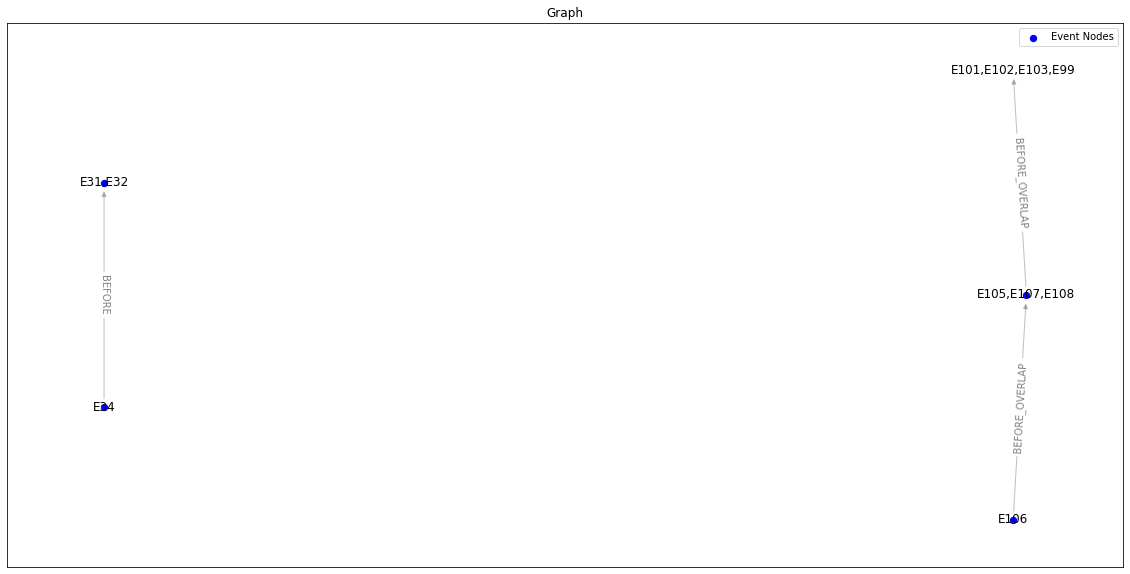

In [81]:
nodes = interval_to_nodes['1999-03-30 00:00:00 - 1999-03-30 23:59:59']
 
def merge_overlapping_nodes(G):
    
    # 先找出所有 "overlap" 关系的连通分量
    overlap_graph = nx.Graph()
    for u, v, attrs in G.edges(data=True):
        if attrs.get("type").lower() in ["overlap", "simultaneous"]:  # 只保留 overlap 关系
            overlap_graph.add_edge(u, v)

    # 计算所有需要合并的节点组
    merged_nodes = {}
    merged_attrs = {}
    for comp in nx.connected_components(overlap_graph):
        merged_id = ",".join(map(str, sorted(comp)))  # 生成合并后的新 id
        merged_type = "+".join(sorted(set(G.nodes[n].get("type", "") for n in comp if "type" in G.nodes[n])))
        merged_text = "+".join(sorted(set(G.nodes[n].get("text", "") for n in comp if "text" in G.nodes[n])))
        
        merged_attrs[merged_id] = {"type": merged_type, "text": merged_text}
        for node in comp:
            merged_nodes[node] = merged_id  # 记录合并映射

            
    # 构建新的有向图
    newG = nx.DiGraph()
    for node in G.nodes():
        new_node = merged_nodes.get(node, node)  # 如果在 merge 中，就替换成新 id
        if new_node not in newG:
            newG.add_node(new_node, **merged_attrs.get(new_node, G.nodes[node]))

    # 重新添加边，保持所有原有的边属性
    for u, v, attrs in G.edges(data=True):
        merged_u = merged_nodes.get(u, u)  # 如果 u 被合并，就用新 id
        merged_v = merged_nodes.get(v, v)  # 如果 v 被合并，就用新 id

        if merged_u != merged_v or attrs.get("type").lower() not in ["overlap", "simultaneous"]:  # 避免 self-loop
            newG.add_edge(merged_u, merged_v, **attrs)

    return newG 

def get_subgraph_of_interval(G, nodes):
    subgraph = G.subgraph(nodes).copy() 
    
    # 合并overlap
    subgraph = merge_overlapping_nodes(subgraph)
    # 找出孤立节点
    isolated_nodes = list(nx.isolates(subgraph))
    # 移除孤立节点
    subgraph.remove_nodes_from(isolated_nodes)
    return subgraph

subgraph = get_subgraph_of_interval(G, nodes)
draw_graph(subgraph, show_edge_labels=True)


In [82]:
def find_distinct_paths(G):
    all_paths = []
    for start in G.nodes:
        for end in G.nodes:
            if start != end:
                for path in nx.all_simple_paths(G, source=start, target=end):
                    all_paths.append(path)
    
    # 去除被完全包含的路径
    filtered_paths = []
    for path in all_paths:
        if not any(set(path) < set(other_path) for other_path in all_paths if path != other_path):
            filtered_paths.append(path)
    
    return filtered_paths

def find_distinct_paths_dag(G):
    """可能效率更高"""
    # 确保图是 DAG
    if not nx.is_directed_acyclic_graph(G):
        raise ValueError("Graph must be a DAG for this method to work efficiently")

    # 进行拓扑排序
    topo_order = list(nx.topological_sort(G))

    # 记录每个节点的所有路径
    paths = {node: [] for node in topo_order}

    # 反向遍历拓扑序，构建所有路径
    for node in reversed(topo_order):
        successors = list(G.successors(node))
        if not successors:
            paths[node].append([node])
        else:
            for succ in successors:
                for path in paths[succ]:
                    paths[node].append([node] + path)

    # 过滤掉被完全包含的路径
    all_paths = [p for path_list in paths.values() for p in path_list]
    distinct_paths = []
    for path in all_paths:
        if not any(set(path) < set(other) for other in all_paths if path != other):
            distinct_paths.append(path)

    return distinct_paths

paths = find_distinct_paths_dag(subgraph)
print_paths(subgraph, paths, abbr_path=False)
 

(E34, PROBLEM, shortness of breath) -> [BEFORE] -> (E31,E32, PROBLEM, confused+disoriented)
(E106, PROBLEM, pneumonia) -> [BEFORE_OVERLAP] -> (E105,E107,E108, TREATMENT, Levaquin+The antibiotic+antibiotics) -> [BEFORE_OVERLAP] -> (E101,E102,E103,E99, PROBLEM+TEST, A chest x-ray+pulmonary edema+the chest x-ray+the opacities)
